## Chapter 14: Tree-based learners

# 14.4 Classification Trees

You can toggle the code on and off in this presentation via the button below.

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

While we can apply regression trees directly to the problem of classification (as described in Section 14.5 in the context of *boosting*) the fact that classification data has *discrete output* naturally provokes a unique application of binary trees to the problem of classification. With so-called *classification trees* we apply the same fundamental binary tree-based approximators, but with important differences in how both *leaf values* and *split-points* are chosen. 

In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import autograd.numpy as np
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'
 
# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook

# plotting
import matplotlib.pyplot as plt
import copy

%load_ext autoreload
%autoreload 2

##  Classification Stumps

- For the same practical reasons described for regression we cannot use local optimization to determine an optimal choice for all parameters of a classification stump simultaneously. 

- Instead we must again test out a variety of choices - different stumps consisting of different split-points and leaf values - in search of the ideal. 

- Because the output of classification data is *discrete*, instead of assigning leaf values based on the *mean of the output* on either side of a split point, which can create numerical values that do not belong to either class, we can assign leaf values based on the *mode of the output* (the *majority vote*).

However with this dataset we can also see that there is a problem with using the *mode* as well: for every candidate stump (whose split-point is a midpoint between two consecutive inputs) the mode on *both sides* always equals $-1$ (i.e., every stump is *perfectly flat*). 

In the right panel of the figure we show the data with each of its $9$ split-point highlighted by a vertical dashed blue line, with the (completely flat) stump found in each instance colored red.  

In other words, using the mode we cannot determine any of the nonlinear phenomenon present in this simple dataset.

<IPython.core.display.Javascript object>


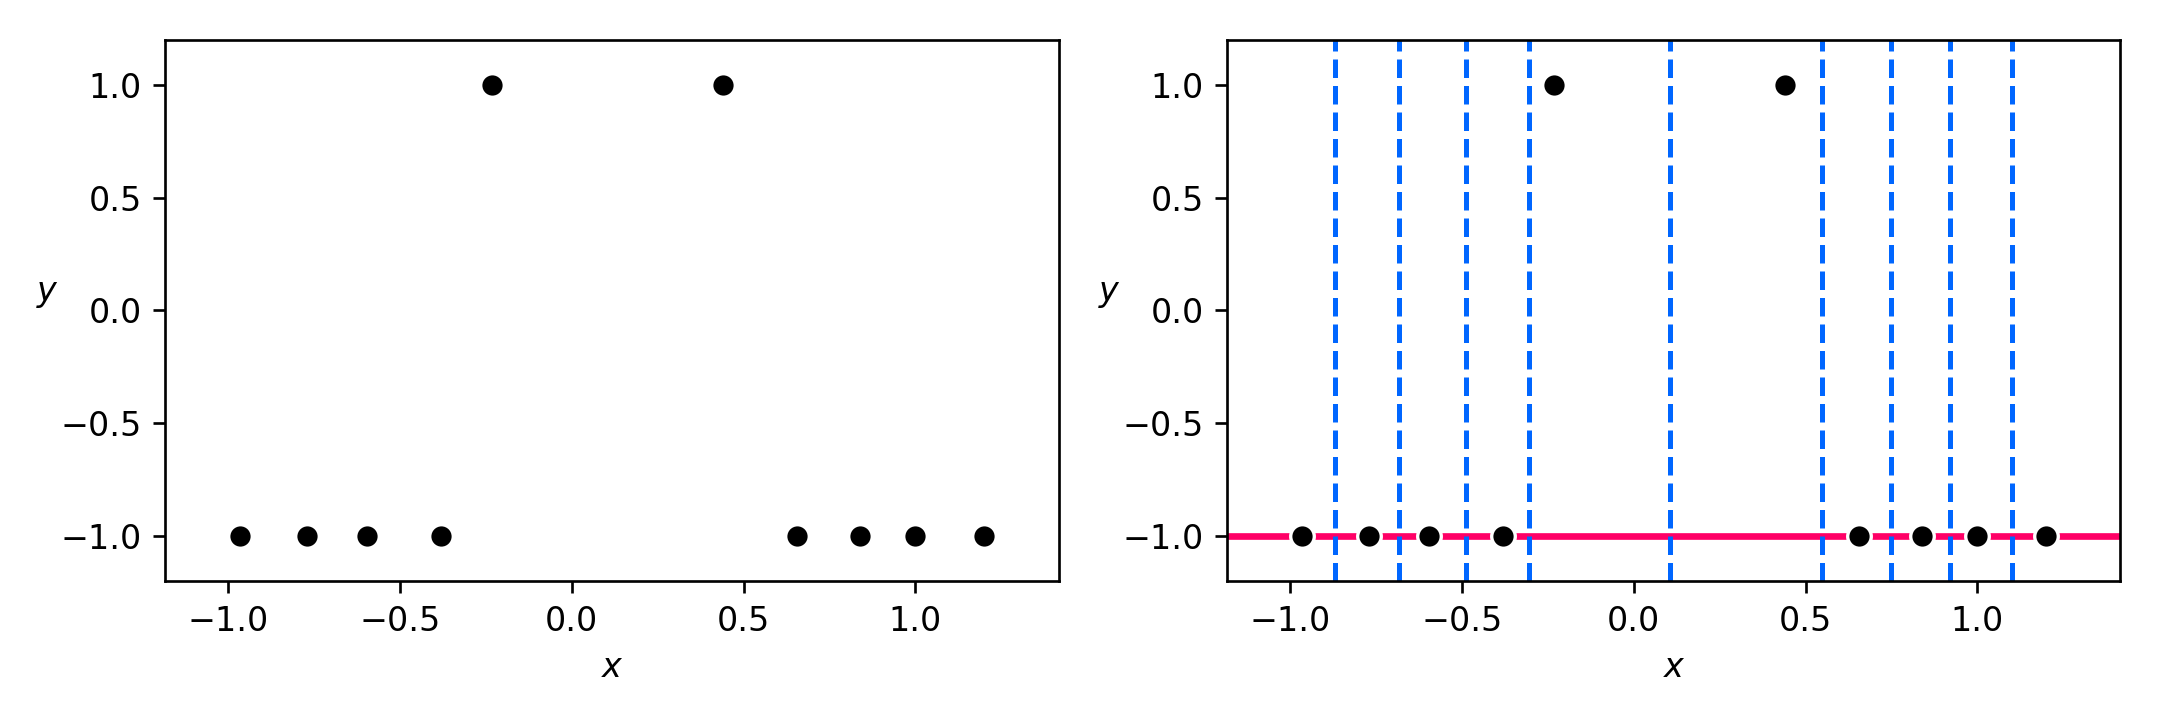

In [19]:
## This code cell will not be shown in the HTML version of this notebook
# load in data and plot stumps based on weighted majority vote
csvname = datapath + 'signed_projectile_2.csv'
demo = nonlib.classification_tree_demo.Visualizer(csvname)
demo.plot_original()

- Using the *mode* as opposed to the *mean* would keep our leaf values constrained to discrete labels of our data, providing more appropriate stumps. 

- To compensate for potential class imbalances in a particular leaf, a *balanced majority vote* is typically used that weights each 'vote' in determining a leaf's value by the fraction of total dataset belonging to each class.  

- This means that  instead of setting a leaf value to the most *common* label value it contains, we compute the fraction $\frac{\text{number of points from class $c$ in leaf}}{\text{total number of points from class $c$ in dataset}}$ for each class, and assign the leaf the label value $c$ with the largest fraction.


The figure below shows the result of setting the leaf values of each of the $9$ candidate stumps using the balanced majority voting scheme.  Instead of a completely flat stump (in all but the fifth instance, whose split-point is highlighted with a dashed blue line) here we have a variety of reasonable stumps to choose from.  To see how the weighted majority was used to define the leaf values in this instance let us examine a few of the stumps more closely.  Note that in this dataset there are $8$ datapoints in the $-1$ class and $2$ in the $+1$ class.

- The first stump, illustrated in the top left panel, has a left leaf value of $-1$ and a right leaf value of $+1$.  Since only a single datapoint with label value $-1$ exists left of the split-point the vote of the $-1$ class is $\frac{1}{8}\times 1 = \frac{1}{8}$ while that of the $+1$ class is $\frac{1}{2} \times 0 = 0$, and hence the leaf is given value $-1$.  The right leaf contains $7$ points with $-1$ label and $2$ points with $+1$ label, hence the weighted majority vote of each class is $\frac{1}{8}\times 7 = \frac{7}{8}$ and $\frac{1}{2} \times 2 = 1$ respectively, and thus the leaf value is assigned value $+1$.



- The sixth stump, illustrated in the middle right panel, has a left leaf value of $+1$ and a right leaf value of $-1$.  Four points with label $-1$ and two points with label $+1$ lie to the left of the split-point, thus the weighted majority vote of the two classes is $\frac{1}{8}\times 4 = \frac{1}{2}$ and $\frac{1}{2}2 = 1$ respectively (hence the leaf value is $+1$).  Likewise the weighted majority votes to the right of the split point are for labels $-1$ and $+1$ given as $\frac{1}{8}4 = \frac{1}{2}$ and $\frac{1}{2}0 = 0$ respectively, thus the leaf value here is $-1$.

<IPython.core.display.Javascript object>


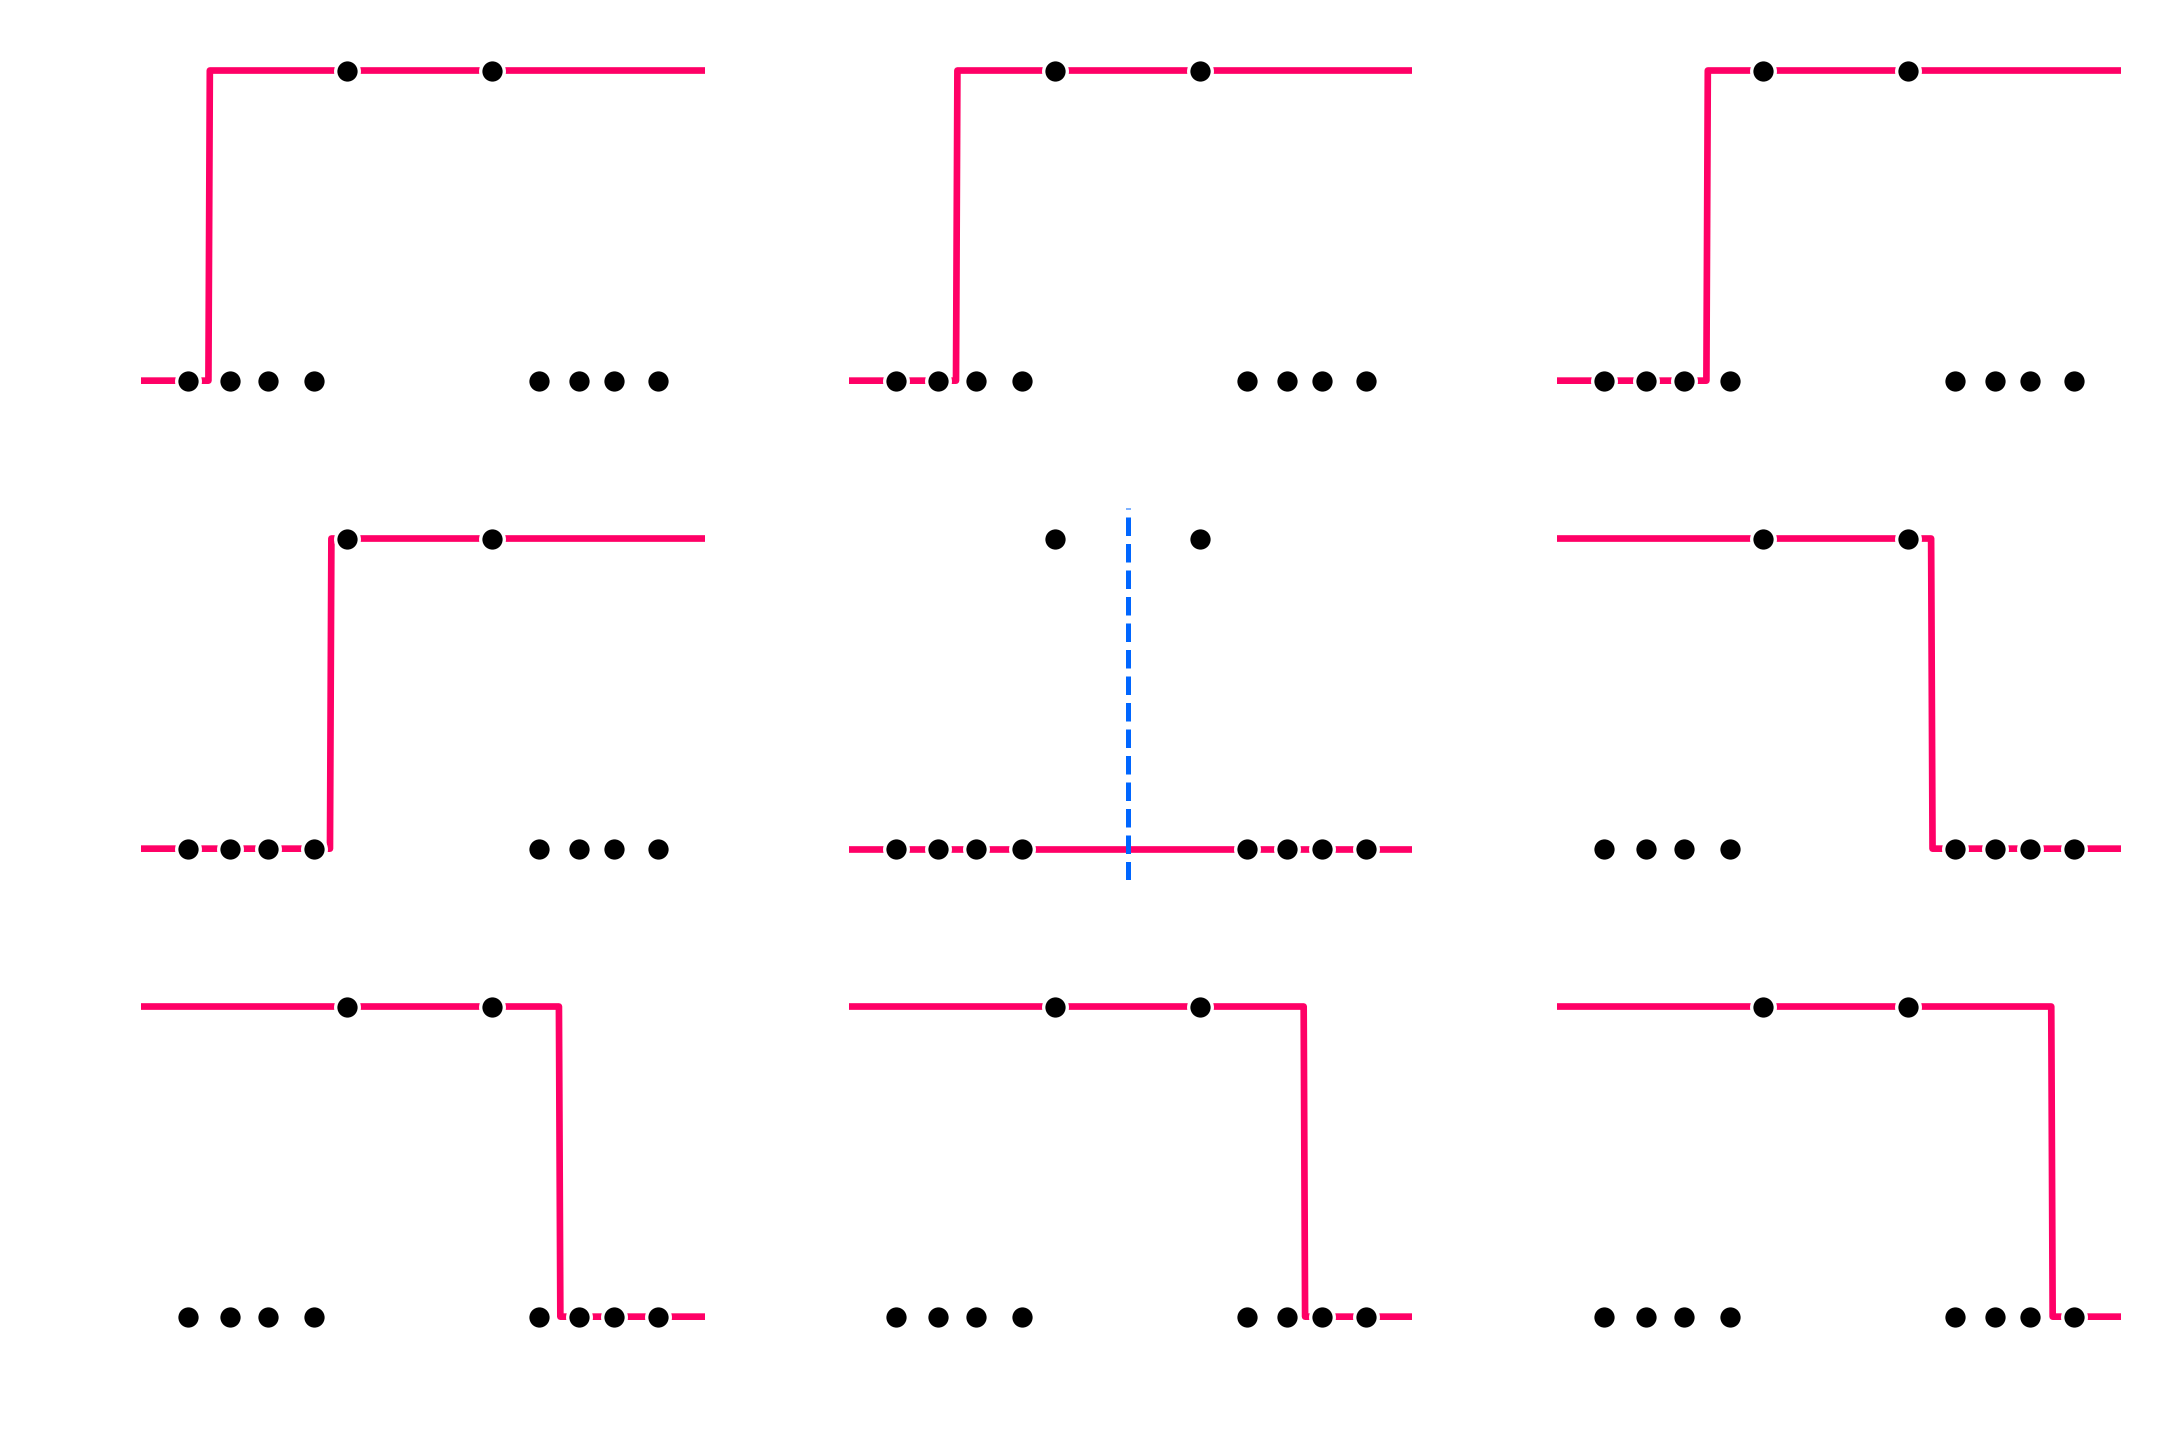

In [14]:
## This code cell will not be shown in the HTML version of this notebook
# load in data and plot stumps based on weighted majority vote
csvname = datapath + 'signed_projectile_2.csv'
demo = nonlib.classification_tree_demo.Visualizer(csvname)
demo.multistump_plotter()

- In order to determine an optimal split point we can employ a two-class accuracy metric like *balanced accuracy*.  

- In the context of classification trees accuracy metrics are often called *purity* metrics, since they measure how *pure* each leaf of the stump is in terms of class representation.

- As with regression stumps, with large datasets a range of efficiency shortcuts may be taken in practice to limit the number of stumps tested including coarser selections of split-points, testing only a random subset of input dimensions, etc.  

Below we illustrate the resulting balanced accuracy of each stump shown above.  Here we can see that *two* options provide the maximum (desired) metric, those stumps on strafing the $+1$ class.


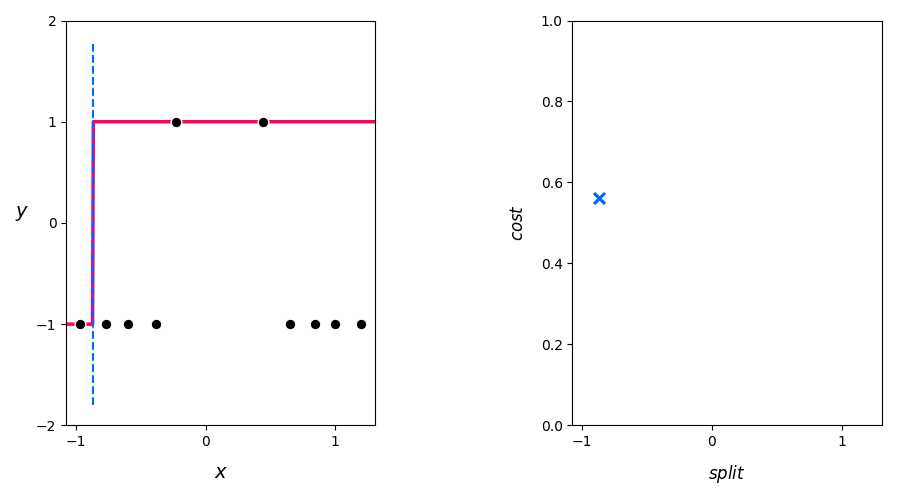
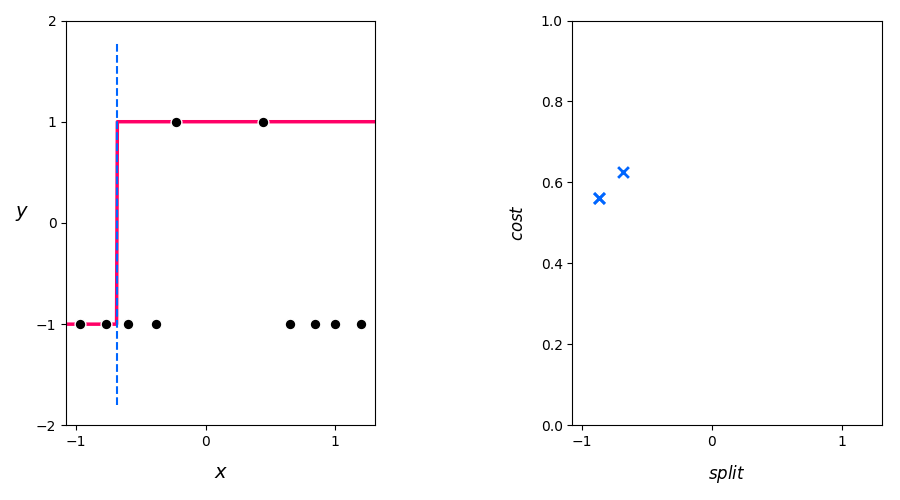
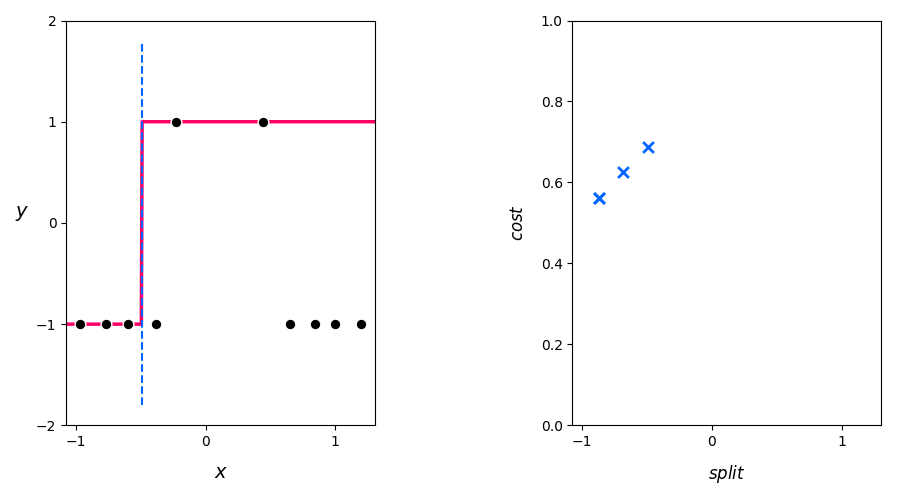
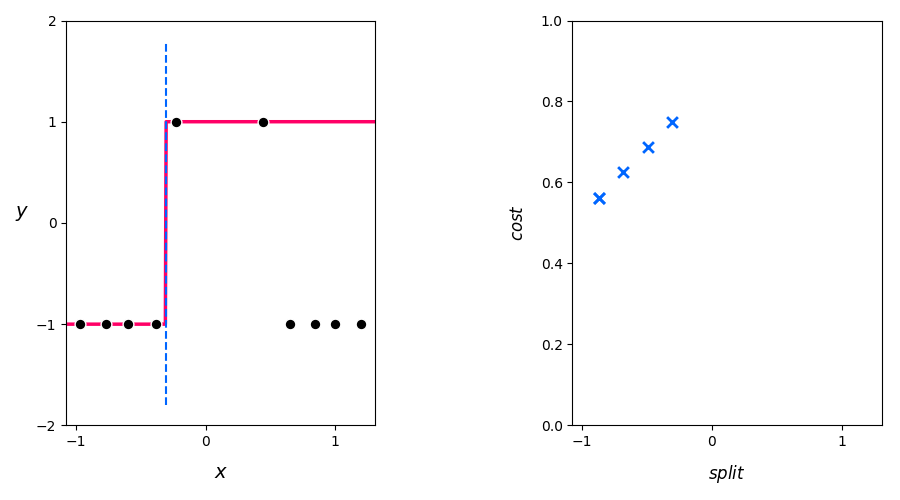
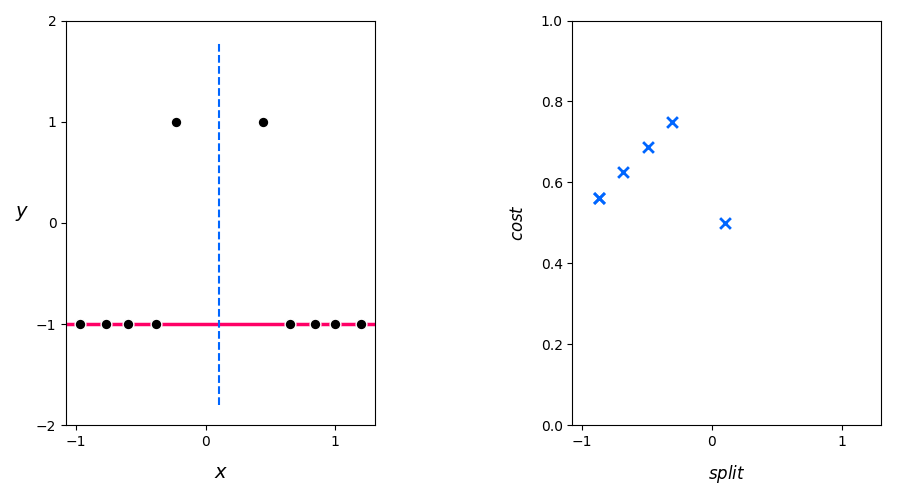
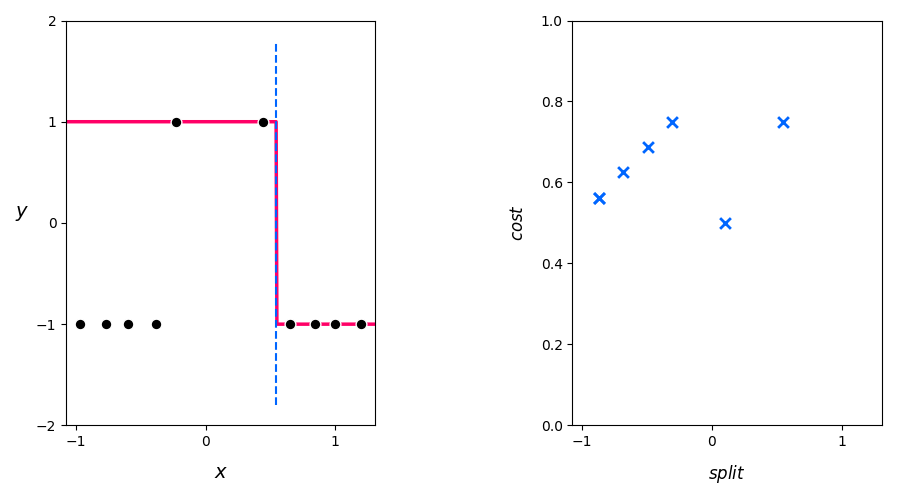
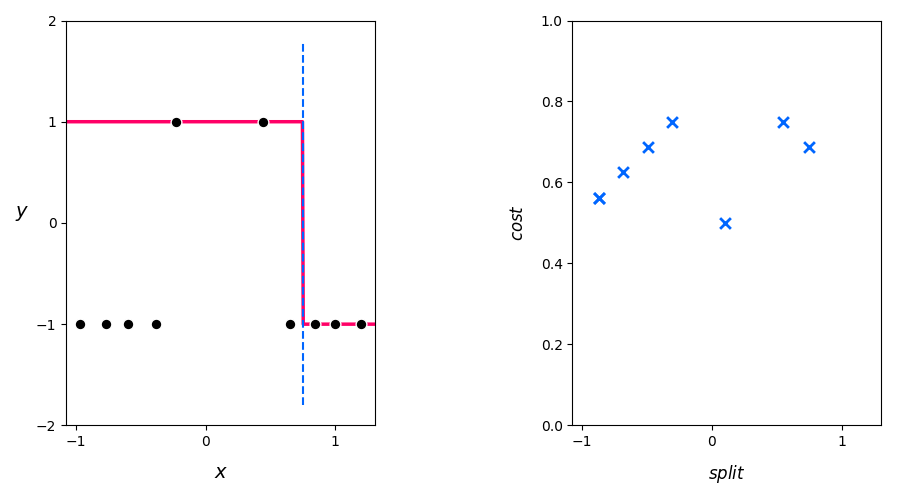
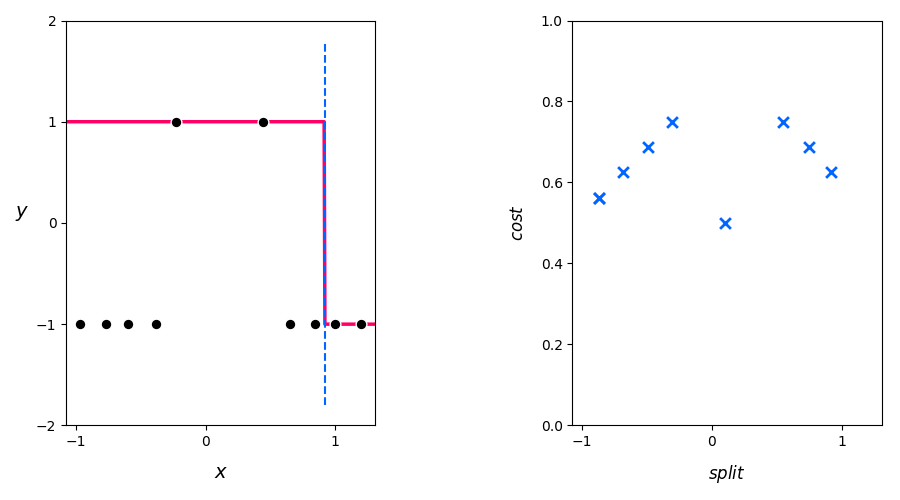
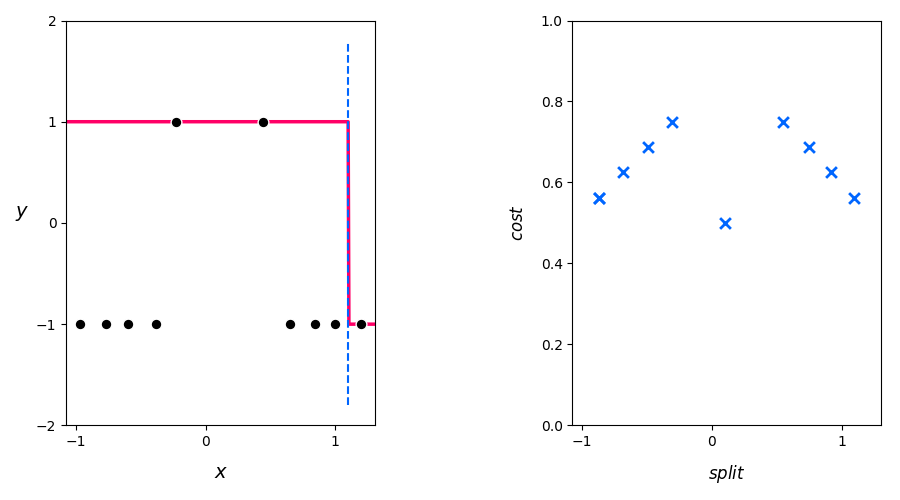

In [30]:
## This code cell will not be shown in the HTML version of this notebook
# animate stump collection for a sample dataset
demo = nonlib.stump_classification_visualizer_2d.Visualizer()
csvname = datapath + 'signed_projectile_2.csv'
demo.load_data(csvname)
demo.browse_stumps()

##  Classification Trees of Maximum Depth

To build deeper trees we recurse on the two leaves of a stump and treat each like we did the original data, building a stump out of each splitting them precisely as detailed above. 

Just as with regression trees, with classification we have binary trees of a *maximum depth*, as certain branches halt under obvious and/or user-defined conditions. 

- With classification, one natural halting condition is when a leaf is *completely pure*, that is it contains only members of a single class. 

Other usef-defined halting conditions like a minimum number of points on a leaf are also often used in practice. 

Below we illustrate the growth of a maximum depth two tree to the toy two-class dataset shown above.  Here we can see that after the initial stump is set *we no longer split its left leaf since it is completely pure* (containing all points from the $-1$ class).  Thus while the leaf on the left halts at *depth one* the leaf on the right grows to a depth of two.


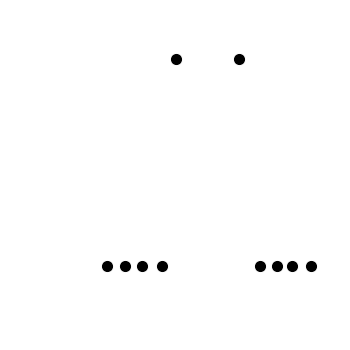
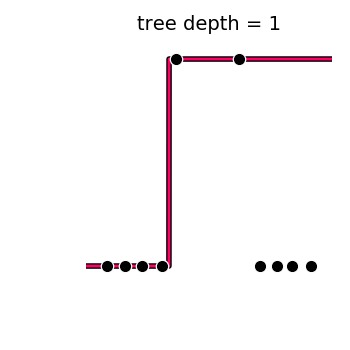
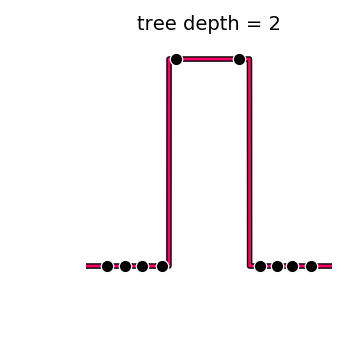

In [19]:
# learn classification tree for input dataset
csvname = datapath + 'signed_projectile_2.csv'
depth = 2
tree = nonlib.recursive_tree_lib.ClassificationTree.RTree(csvname,depth)

# animate growth
demo = nonlib.recursive_tree_lib.regression_animator.Visualizer(csvname)
frames = depth
demo.animate_trees(tree)

Below we show another example using an $N=2$ input two-class dataset.  As the tree grows note how many parts of the space do not change as leaves on the deeper branches become pure.  By the time we reach a maximum depth of seven we have considerably overfit the dataset.


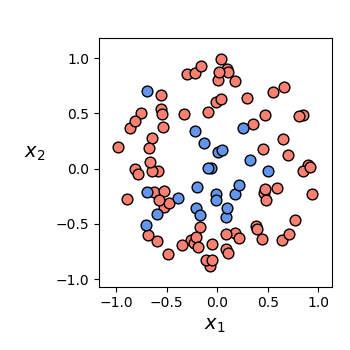
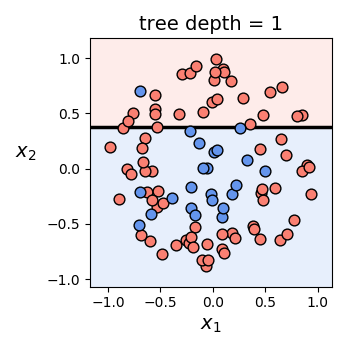
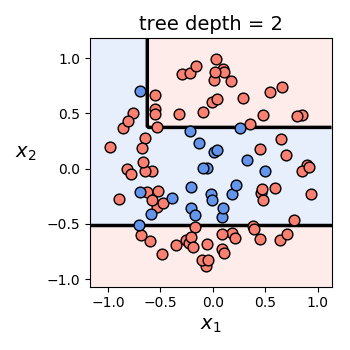
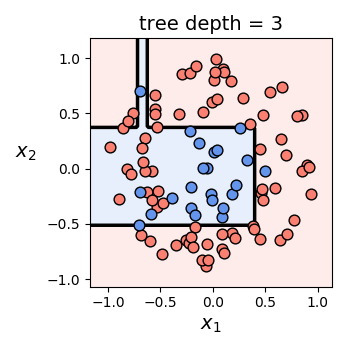
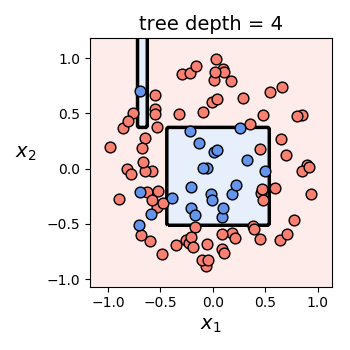
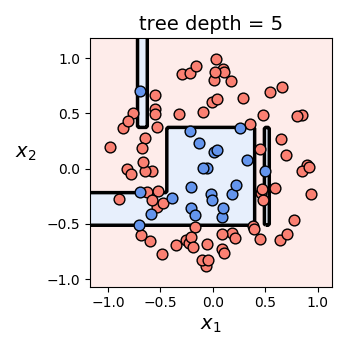
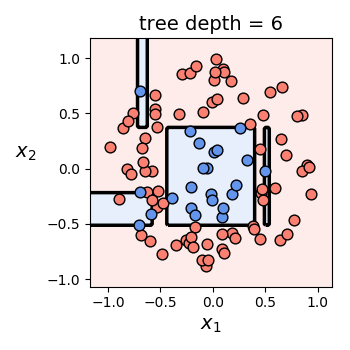
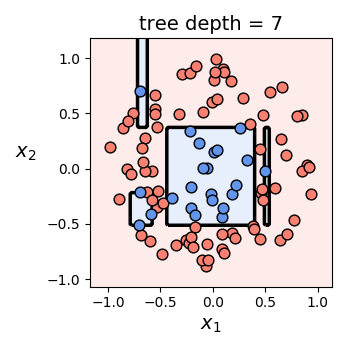

In [17]:
## This code cell will not be shown in the HTML version of this notebook
# learn classification tree for input dataset
csvname = datapath + 'new_circle_data.csv'
depth = 7
tree = nonlib.recursive_tree_lib.ClassificationTree.RTree(csvname,depth)

# animate growth
demo = nonlib.recursive_tree_lib.classification_animator.Visualizer(csvname)
demo.animate_trees(tree)

An example of a maximum depth seven tree is shown below fit to a $N=2$ multiclass dataset as well. 


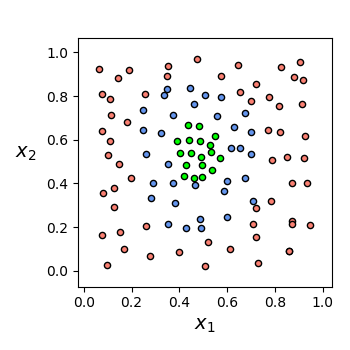
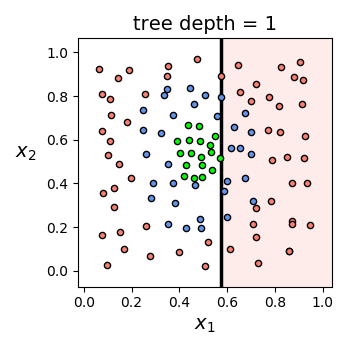
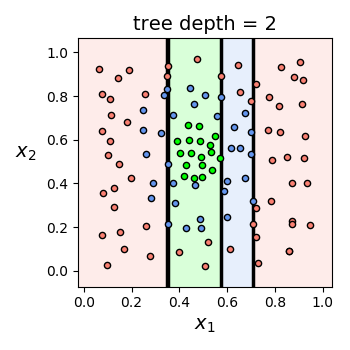
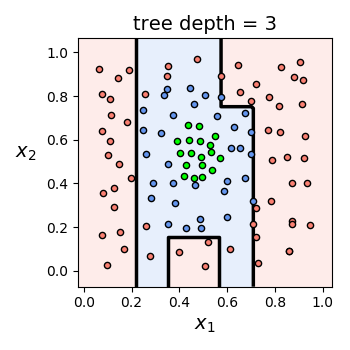
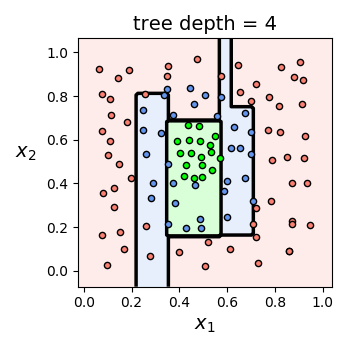
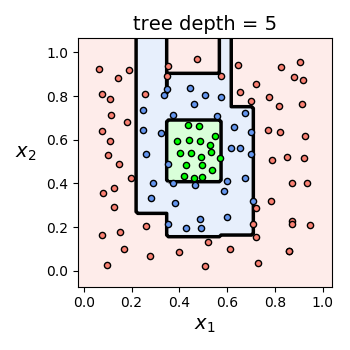
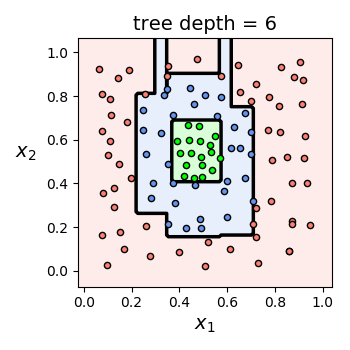
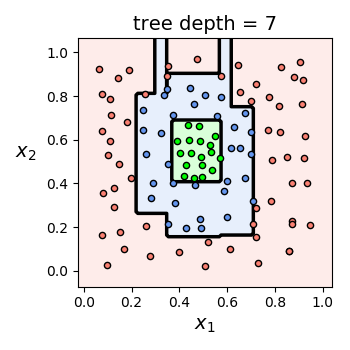

In [27]:
## This code cell will not be shown in the HTML version of this notebook
# learn classification tree for input dataset
csvname = datapath + '3_layercake_data.csv'

# learn classification tree for input dataset
depth = 7
tree = nonlib.recursive_tree_lib.ClassificationTree.RTree(csvname,depth)

# animate growth
demo = nonlib.recursive_tree_lib.classification_animator.Visualizer(csvname)
demo.animate_trees(tree,pt_size = 20)